# Coffee Data Analysis (Group 37)
Alexandra Ramassamy, Alyssa Chang, Helen Zhao, Katherine Hunter, Kushagra Chitkara\
**Dataset**: https://www.kaggle.com/datasets/volpatto/coffee-quality-database-from-cqi

## Problem statement
The Coffee Quality Institute provides coffee evaluations using tasting experts who score the coffees based on features such as acidity, body, and balance... and one subjective 'overall' scoring, but what contributes to this subjective component?  We set out to determine what features cause a coffee to receive a higher rating, and whether other variables like coffee origin contribute.

**Question : Which features mostly impact our appreciation of the taste of coffee (the general grade given to a coffee) ?**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from scipy.stats import zscore
import xgboost as xgb
from sklearn.decomposition import PCA
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
# sklearn imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [5]:
df = pd.read_csv('data/merged_data_cleaned.csv')
#df = pd.read_csv('drive/MyDrive/209A Coffee Project/data/merged_data_cleaned.csv')

## Explore and Visualize Data

In [6]:
print("The shape of the coffee dataset is:",df.shape)

The shape of the coffee dataset is: (1339, 44)


In [7]:
# We noticed that at list one line is a "test" line and does not correspond to coffee samples
df[df["ICO.Number"]=="TEST"]

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
170,170,Arabica,alexandra katona-carroll,Brazil,NaN,NaN,NaN,TEST,NaN,test,...,NaN,0,"March 21st, 2012",NUCOFFEE,567f200bcc17a90070cb952647bf88141ad9c80c,aa2ff513ffb9c844462a1fb07c599bce7f3bb53d,m,NaN,NaN,NaN


### Interaction between columns when we remove outliers

Size before quality feature outlier removal: (1339, 12)
Size after quality feature outlier removal: (1205, 12)


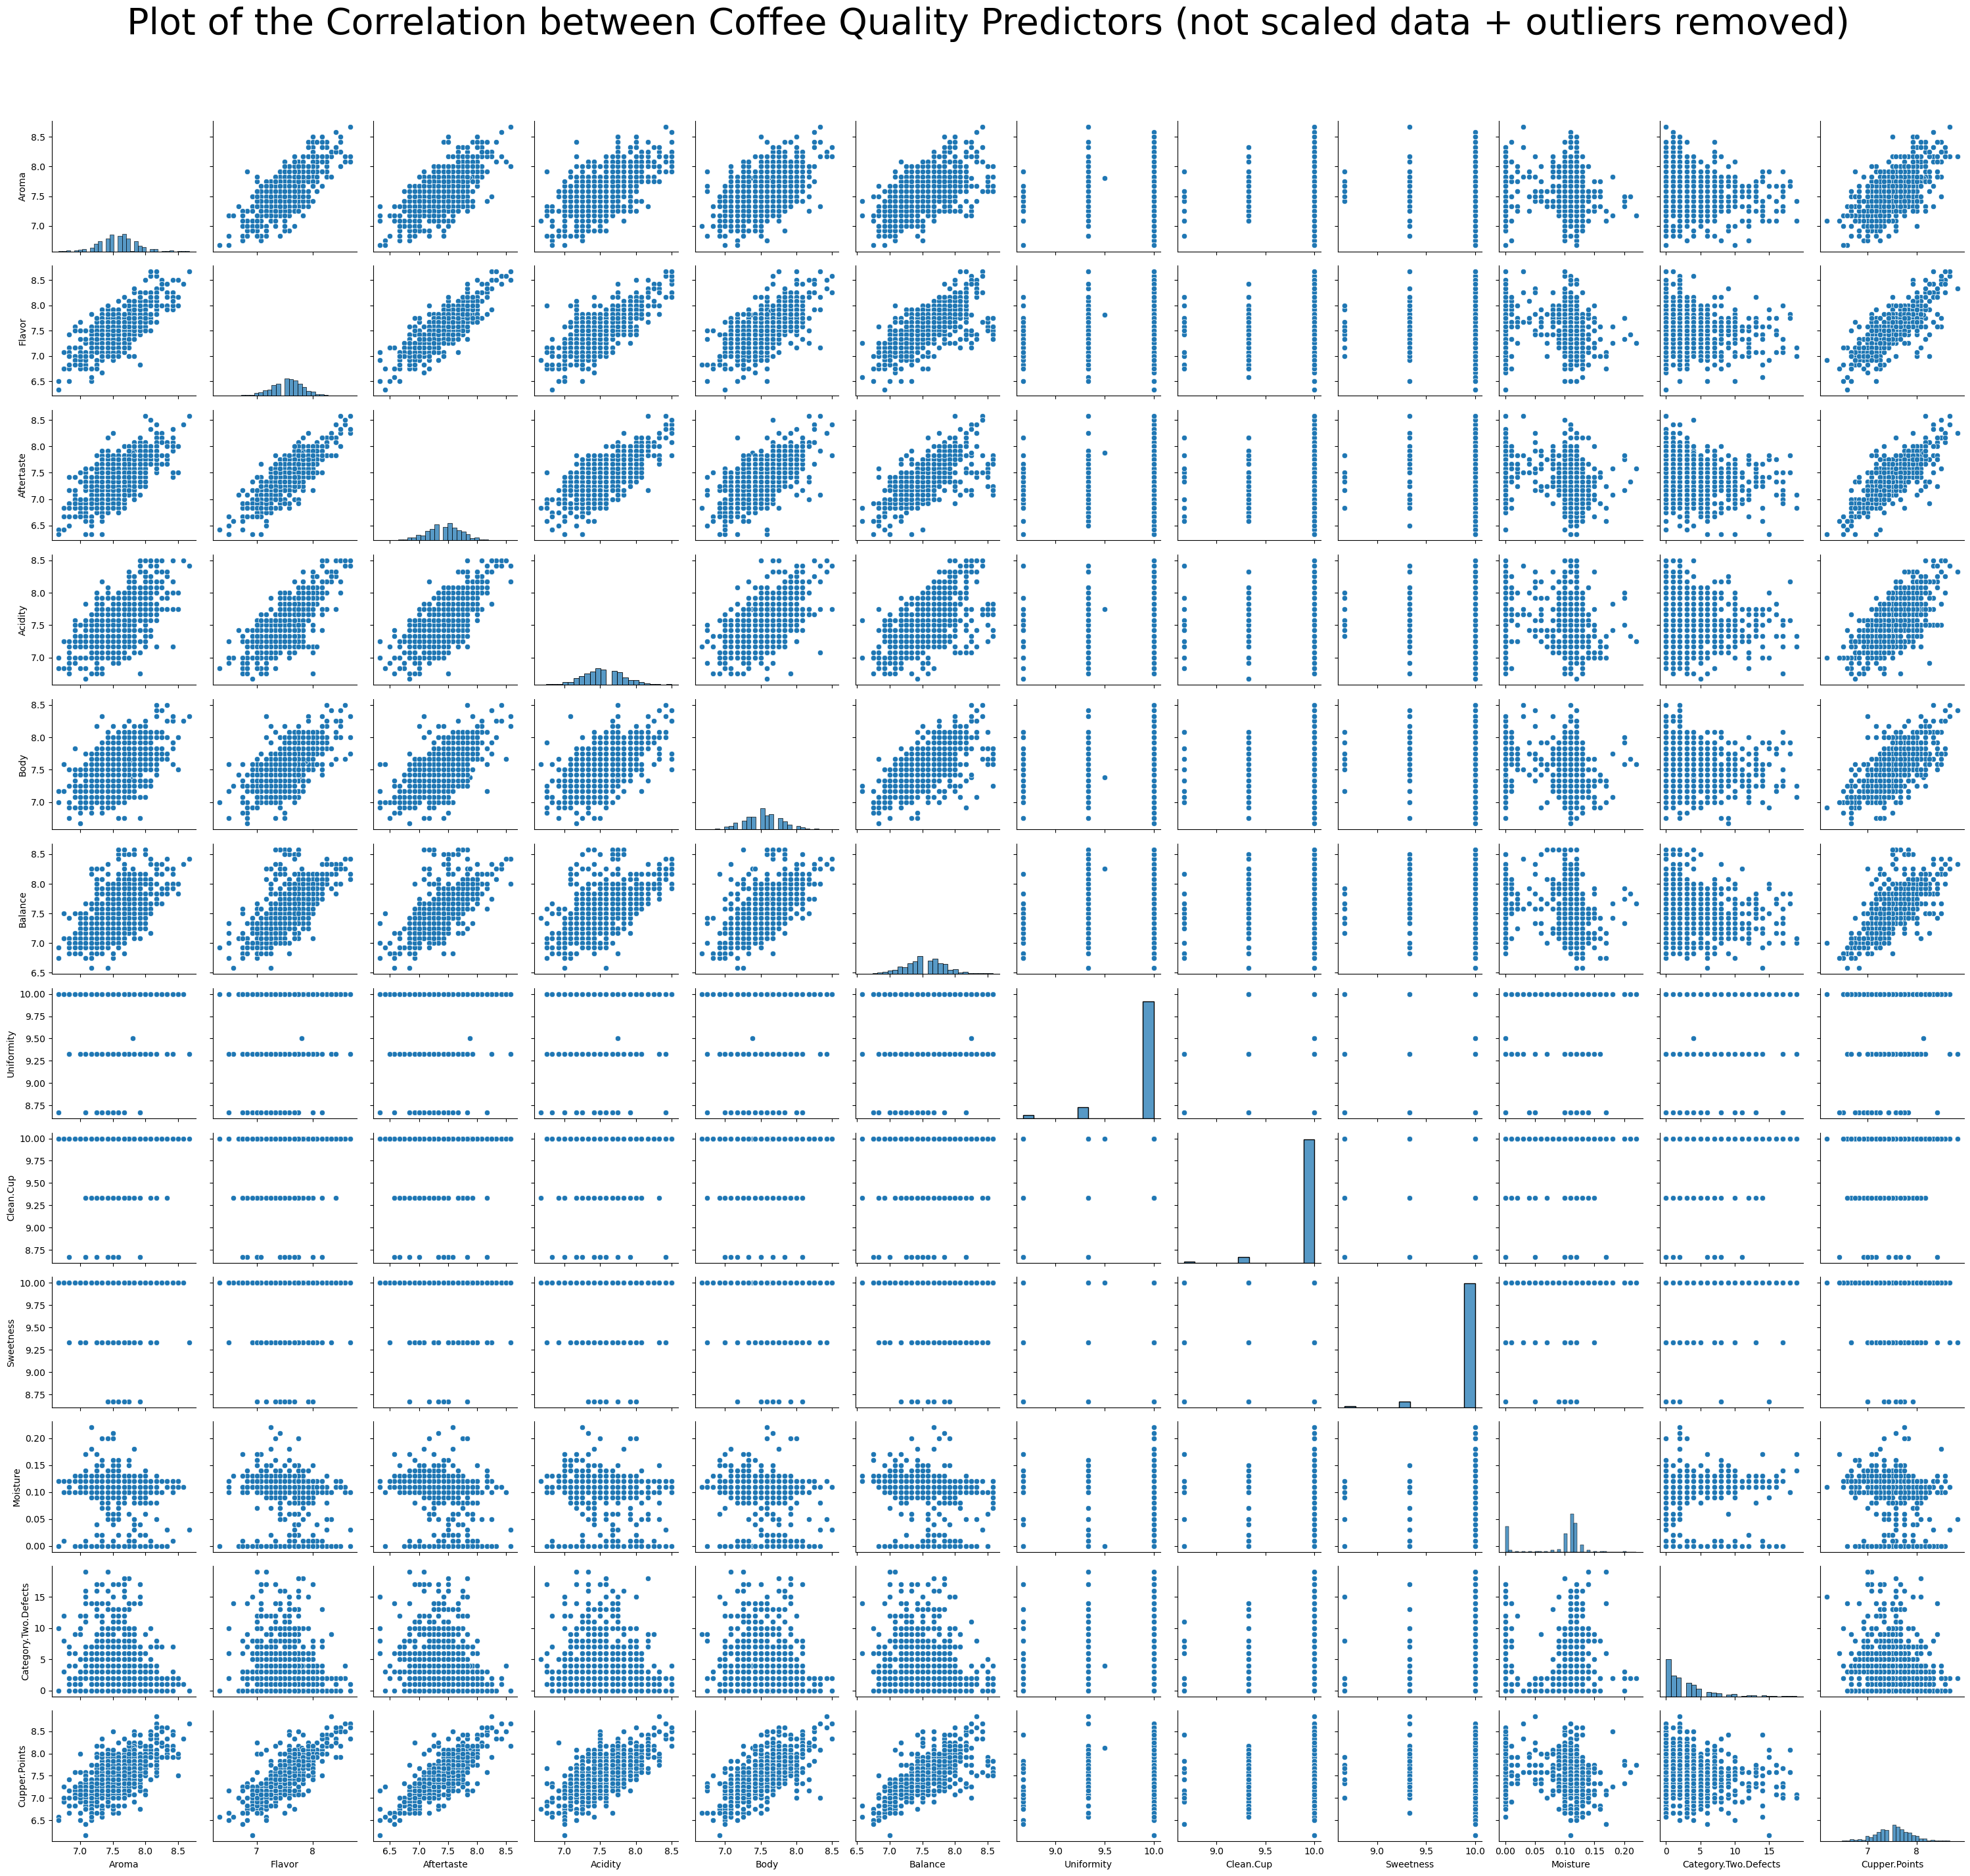

In [8]:
quality_features = ["Aroma","Flavor","Aftertaste","Acidity",
                    "Body","Balance","Uniformity","Clean.Cup",
                    "Sweetness","Moisture","Category.Two.Defects", "Cupper.Points"]
df_quality = df[quality_features]
print("Size before quality feature outlier removal:",df_quality.shape)

# Removing outliers with Z-score +/- 3
df_quality_no_outliers = df_quality[(np.abs(zscore(df_quality)) < 3).all(axis=1)]
print("Size after quality feature outlier removal:",df_quality_no_outliers.shape)

a = sns.pairplot(df_quality_no_outliers)
a.fig.suptitle("Plot of the Correlation between Coffee Quality Predictors (not scaled data + outliers removed)",fontsize=40)
a.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Many variables seems to be correlated. We noticed that 'Total.Cup.Points' was the sum of all the grades. It was the value we initially wanted to predict. However, 'Cupper.Points' is highly correlated to the other grades but is not a function of them but actually reflects a global score given by coffee experts. To generate the previous plot, ~134 outliers were dropped.

### Numerical values exploration

In [9]:
# group columns according to data types
g = df.columns.to_series().groupby(df.dtypes).groups
g = {k.name: list(v) for k, v in g.items()}

df_num = df[g['int64']+g['float64']]
print("Size of numeric data:",df_num.shape)

Size of numeric data: (1339, 20)


In [10]:
# df_num_no_outliers = df_num[(np.abs(zscore(df_num)) < 3).all(axis=1)]

# pca = PCA(2).fit_transform(StandardScaler().fit_transform(df_num_no_outliers))
# df_pca2 = pd.DataFrame(pca, columns=["pca1", "pca2"])
# df_pca2
# fig, ax = plt.subplots()
# ax.scatter(df_pca2["pca1"], df_pca2["pca2"])
# ax.set_title("2 first pca on numerical data")
# ax.set_xlabel("pca1")
# ax.set_ylabel("pca2")

In [11]:
df_num.describe()

,Unnamed: 0,Number.of.Bags,Category.One.Defects,Category.Two.Defects,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Quakers,altitude_low_meters,altitude_high_meters,altitude_mean_meters
count,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1338.000000,1109.000000,1109.000000,1109.000000
mean,669.000000,154.182972,0.479462,3.556385,7.566706,7.520426,7.401083,7.535706,7.517498,7.518013,9.834877,9.835108,9.856692,7.503376,82.089851,0.088379,0.173393,1750.713315,1799.347775,1775.030545
std,386.680316,129.987162,2.549683,5.312541,0.377560,0.398442,0.404463,0.379827,0.370064,0.408943,0.554591,0.763946,0.616102,0.473464,3.500575,0.048287,0.832121,8669.440545,8668.805771,8668.626080
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,334.500000,14.000000,0.000000,0.000000,7.420000,7.330000,7.250000,7.330000,7.330000,7.330000,10.000000,10.000000,10.000000,7.250000,81.080000,0.090000,0.000000,1100.000000,1100.000000,1100.000000
50%,669.000000,175.000000,0.000000,2.000000,7.580000,7.580000,7.420000,7.580000,7.500000,7.500000,10.000000,10.000000,10.000000,7.500000,82.500000,0.110000,0.000000,1310.640000,1350.000000,1310.640000
75%,1003.500000,275.000000,0.000000,4.000000,7.750000,7.750000,7.580000,7.750000,7.670000,7.750000,10.000000,10.000000,10.000000,7.750000,83.670000,0.120000,0.000000,1600.000000,1650.000000,1600.000000
max,1338.000000,1062.000000,63.000000,55.000000,8.750000,8.830000,8.670000,8.750000,8.580000,8.750000,10.000000,10.000000,10.000000,10.000000,90.580000,0.280000,11.000000,190164.000000,190164.000000,190164.000000


In [12]:
#Number of lines which have at least one missing value.
print(f"{np.sum(np.max(df_num.isna(), axis=1))} lines have at least one missing value")

231 lines have at least one missing value


In [13]:
# drop all rows that contain null values for visualization
df_num.dropna(axis=0, inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2696\3852819613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.dropna(axis=0, inplace=True)


**We scale the data to be able to compare them :**

In [14]:
# drop Unnamed: 0 column
df_num = df_num.drop(columns=["Unnamed: 0"])
scaler = StandardScaler().fit(df_num)
x_scaled = pd.DataFrame(scaler.transform(df_num), columns=df_num.columns)

In this plot, the outliers tend to make the data look even more correlated (then we think that the previous pairplot was a more accurate representation:


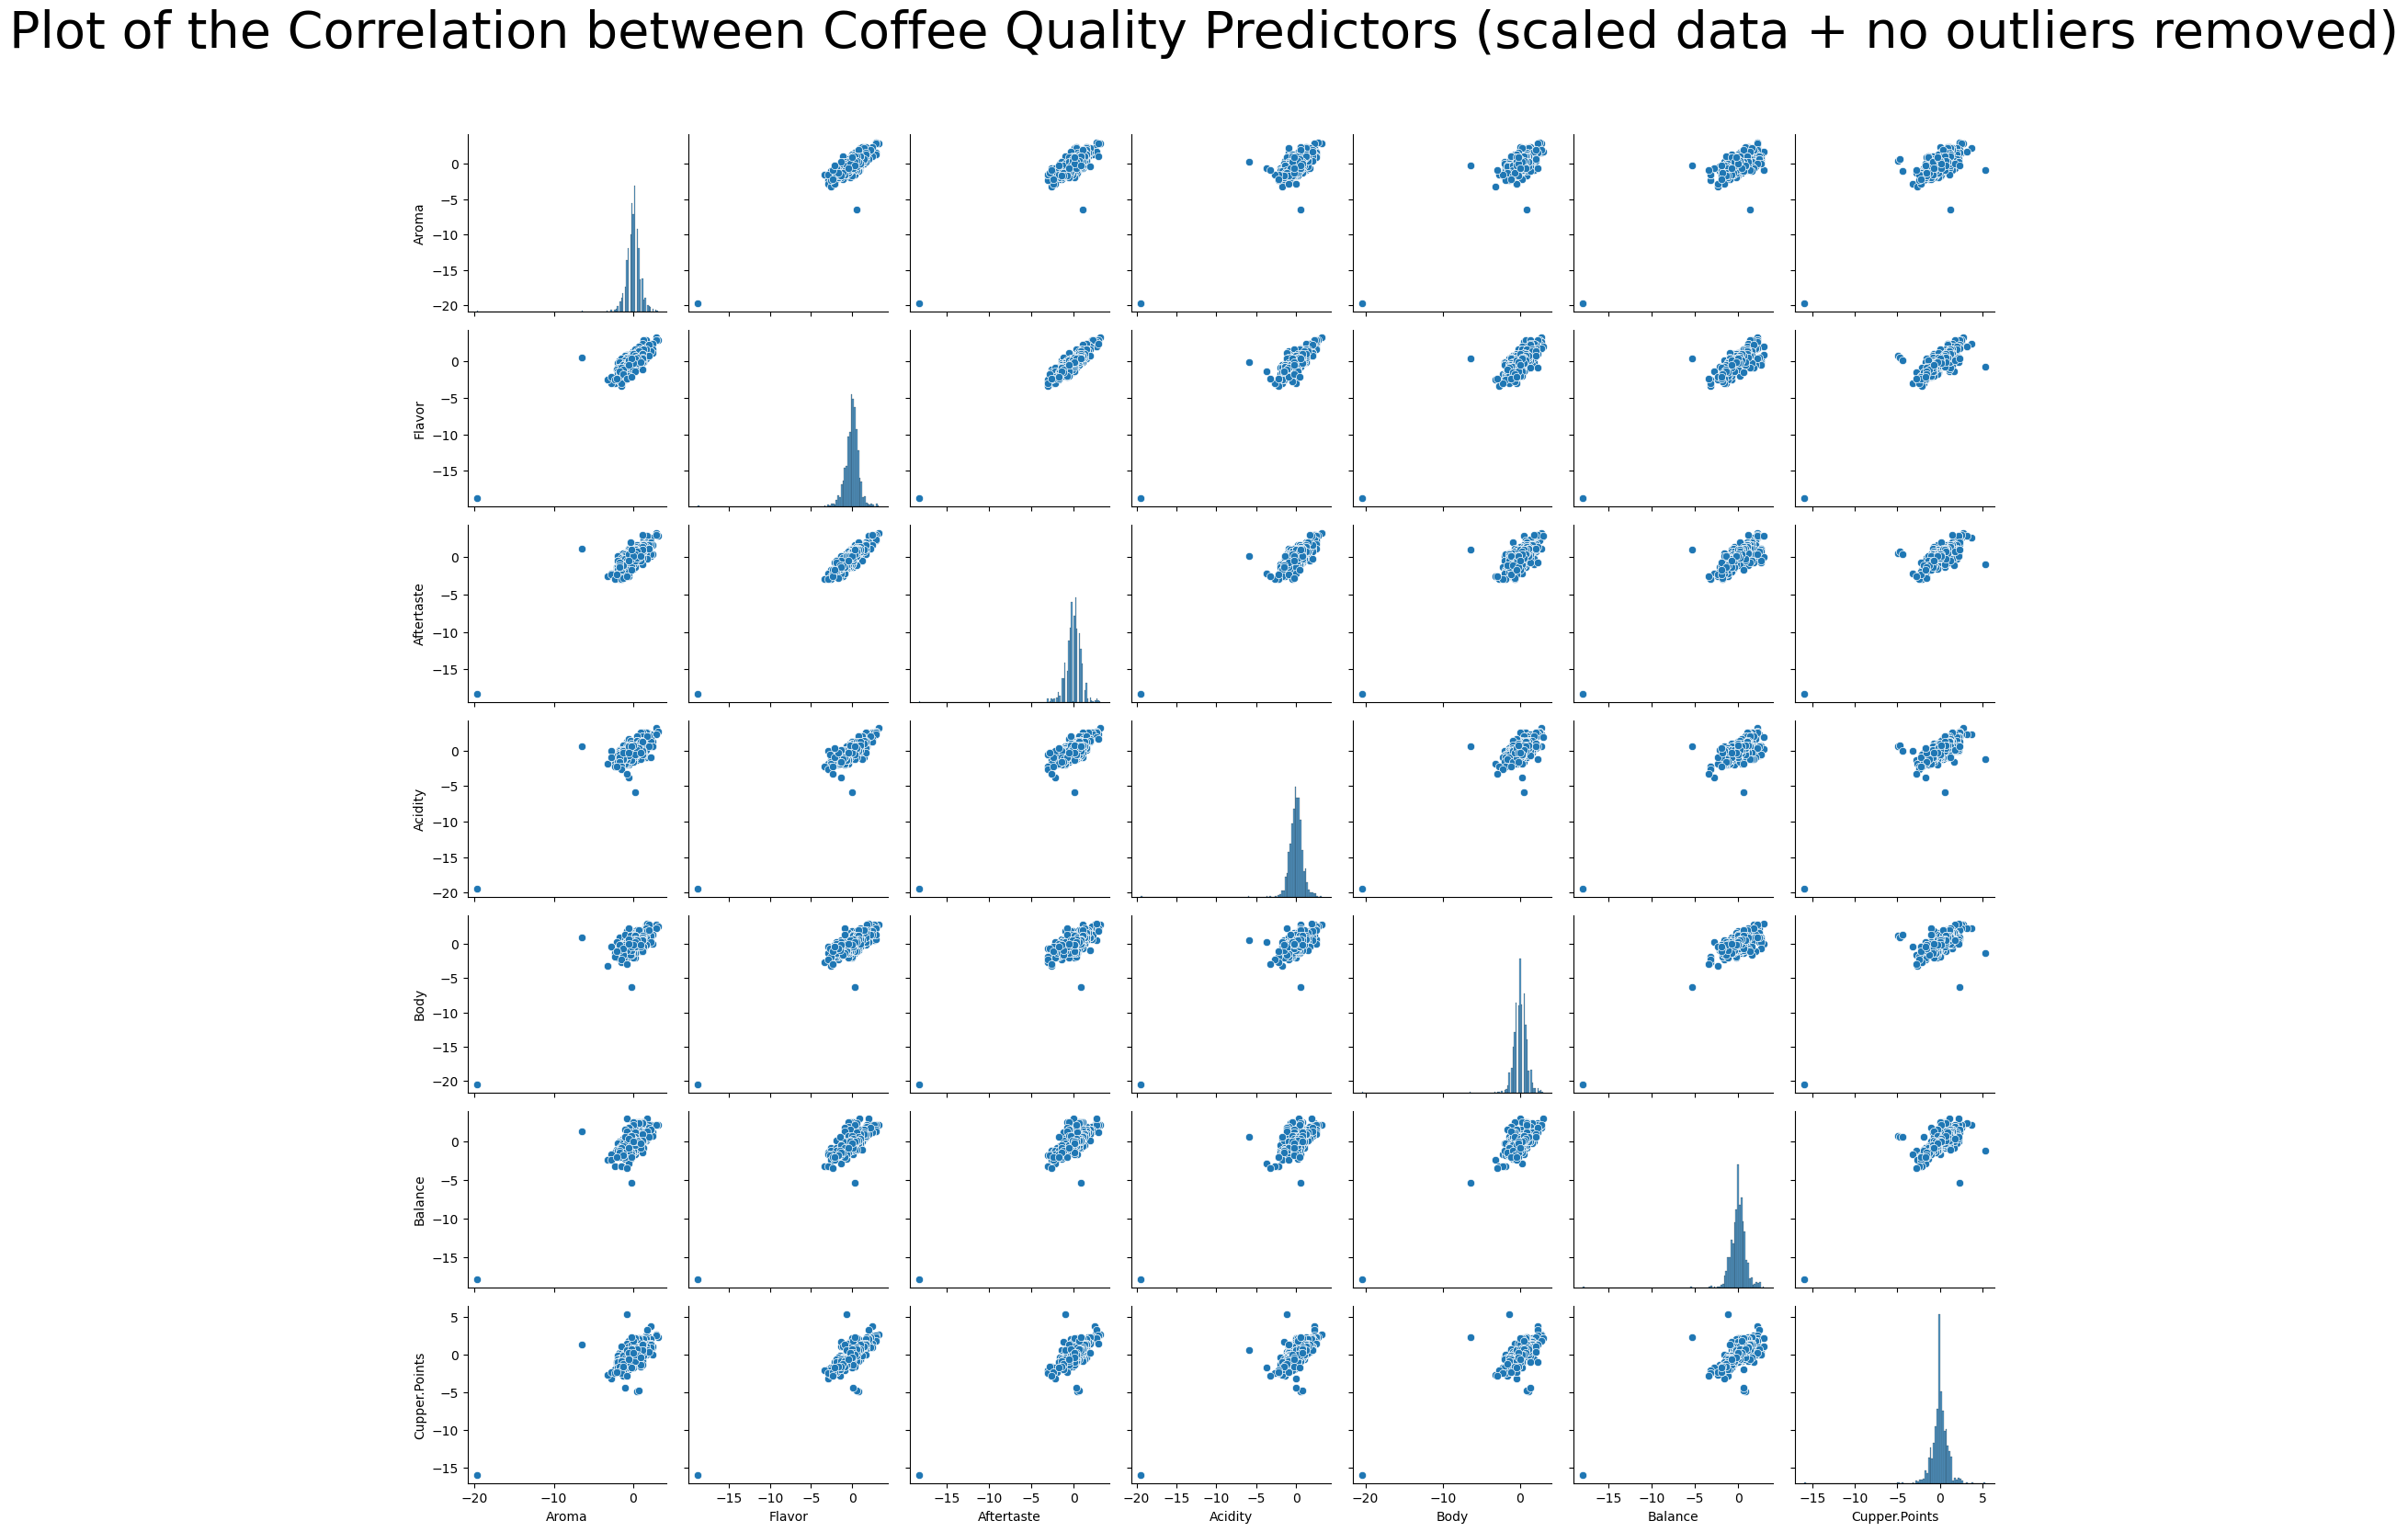

In [15]:
a=sns.pairplot(x_scaled[['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
       'Balance','Cupper.Points']])

a.fig.suptitle("Plot of the Correlation between Coffee Quality Predictors (scaled data + no outliers removed)",fontsize=40)
a.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [16]:
# perform pca decomposition on the scaled numeric data
pca = PCA(2).fit(x_scaled)
df_pca = pd.DataFrame(pca.transform(x_scaled), columns=["pca1", "pca2"])
df_pca

,pca1,pca2
0,-7.506414,0.140368
1,-6.889056,0.128118
2,-6.782712,0.051726
3,-6.046066,0.093115
4,-5.867355,0.115855
...,...,...
1103,0.430334,-0.238466
1104,0.423839,-0.244202
1105,0.995685,0.205980
1106,2.998923,-0.376118


In [17]:
# outliers that skewed the PC2
df_plot = df_pca.merge(df["Species"], left_index=True, right_index=True)
df_plot[df_plot["pca2"]>20]

,pca1,pca2,Species
744,1.199741,37.509521,Arabica
870,1.772752,21.492993,Arabica
952,1.852797,37.941321,Arabica


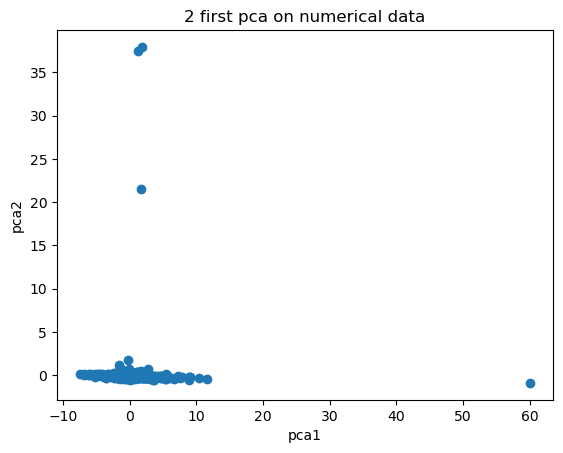

In [18]:
# plot first two pca components of numeric data with outliers
fig, ax = plt.subplots()
ax.scatter(df_pca["pca1"], df_pca["pca2"])
ax.set_title("2 first pca on numerical data")
ax.set_xlabel("pca1")
ax.set_ylabel("pca2")
plt.show()

**We tried to remove the pca outliers lines (`[1082, 744, 870, 952, 868, 949]`) in the original dataset and relaunched the pca then : we still got similar plots where the explaines variance of the second pca component was mostly denerated by a few outliers**

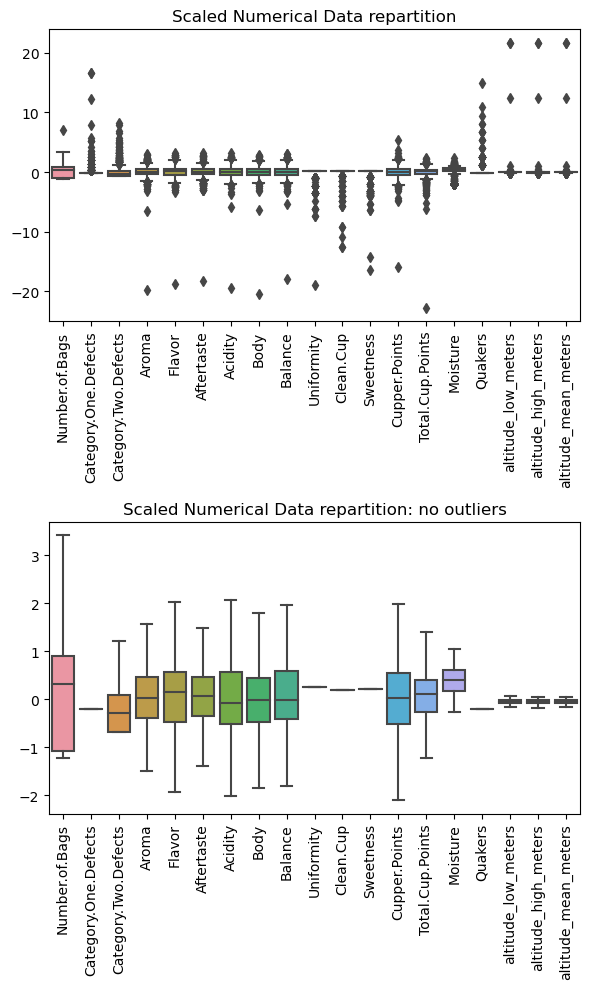

In [19]:
# plot scaled numeric data
fig, ax = plt.subplots(2,1,figsize=[6,10])
sns.boxplot(data=pd.DataFrame(x_scaled, columns=df_num.columns), ax=ax[0])
sns.boxplot(data=pd.DataFrame(x_scaled, columns=df_num.columns), ax=ax[1],showfliers=False)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[0].set_title("Scaled Numerical Data repartition")
ax[1].set_title("Scaled Numerical Data repartition: no outliers")
plt.tight_layout()

The previous plot shows that the predictors "Category.One_Defects", "Uniformity", "Sweetness", "Clean.Cup", and "Quakers" have very low variance (mostly just outliers).

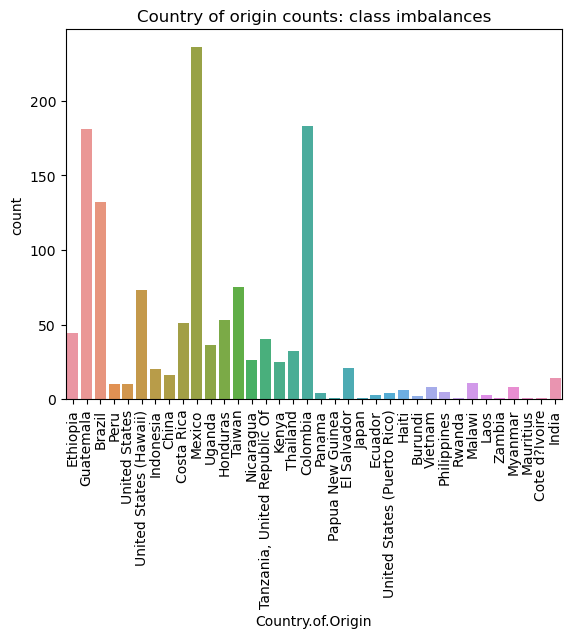

In [20]:
# plot country of origin
sns.countplot(data=df, x='Country.of.Origin')
plt.xticks(rotation=90)
plt.title("Country of origin counts: class imbalances")
plt.show()

The previous plot informed our decision to group the countries of origin into a smaller number of categories.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1339 non-null   int64  
 1   Species                1339 non-null   object 
 2   Owner                  1332 non-null   object 
 3   Country.of.Origin      1338 non-null   object 
 4   Farm.Name              980 non-null    object 
 5   Lot.Number             276 non-null    object 
 6   Mill                   1021 non-null   object 
 7   ICO.Number             1180 non-null   object 
 8   Company                1130 non-null   object 
 9   Altitude               1113 non-null   object 
 10  Region                 1280 non-null   object 
 11  Producer               1107 non-null   object 
 12  Number.of.Bags         1339 non-null   int64  
 13  Bag.Weight             1339 non-null   object 
 14  In.Country.Partner     1339 non-null   object 
 15  Harv

## Data cleaning and preprocessing
We perform the following steps in this section
- Drop irrelevant columns/rows
- Clean text data
- Feature selection
- Imputation
- Train/test split

In [22]:
# drop Unnamed column
df = df.iloc[:,1:]

# drop test datapoint
df = df.drop(df[df['Harvest.Year'] == 'TEST'].index)

print("Dataset shape: ",df.shape)

Dataset shape:  (1338, 43)


In [23]:
df.head(2)

,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [24]:
# split into numeric and categorical features
numeric = df.select_dtypes(include=[np.number])
categorical = df.select_dtypes(exclude=[np.number])
print('NUMERIC:')
print(numeric.columns)
print('\nCATEGORICAL:')
print(categorical.columns)

NUMERIC:
Index(['Number.of.Bags', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
       'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points',
       'Total.Cup.Points', 'Moisture', 'Category.One.Defects', 'Quakers',
       'Category.Two.Defects', 'altitude_low_meters', 'altitude_high_meters',
       'altitude_mean_meters'],
      dtype='object')

CATEGORICAL:
Index(['Species', 'Owner', 'Country.of.Origin', 'Farm.Name', 'Lot.Number',
       'Mill', 'ICO.Number', 'Company', 'Altitude', 'Region', 'Producer',
       'Bag.Weight', 'In.Country.Partner', 'Harvest.Year', 'Grading.Date',
       'Owner.1', 'Variety', 'Processing.Method', 'Color', 'Expiration',
       'Certification.Body', 'Certification.Address', 'Certification.Contact',
       'unit_of_measurement'],
      dtype='object')


In [25]:
# PROCESS BAG WEIGHT DATA
print('Unique Bag.Weight values before processing:')
print(categorical['Bag.Weight'].unique())
def fix_bagweight(text):
    vals = text.split()
    bag_weight = int(vals[0])
    # convert to kilograms
    if len(vals) > 1:
        if vals[1] == 'lbs':
            bag_weight *= 0.453592
    return round(bag_weight)

# add bag weight to numeric, drop from categorical
df['Bag.Weight'] = df['Bag.Weight'].apply(fix_bagweight)
categorical = categorical.drop(columns='Bag.Weight')

print('\nUnique Bag.Weight values after processing:')
print(df['Bag.Weight'].unique())

Unique Bag.Weight values before processing:
['60 kg' '1' '30 kg' '69 kg' '1 kg' '2 kg,lbs' '6' '3 lbs' '50 kg' '2 lbs'
 '100 lbs' '15 kg' '2 kg' '2' '70 kg' '19200 kg' '5 lbs' '1 kg,lbs' '6 kg'
 '0 lbs' '46 kg' '40 kg' '20 kg' '34 kg' '1 lbs' '660 kg' '18975 kg'
 '12000 kg' '35 kg' '66 kg' '80 kg' '132 lbs' '5 kg' '25 kg' '59 kg'
 '18000 kg' '150 lbs' '9000 kg' '18 kg' '10 kg' '29 kg' '1218 kg' '4 lbs'
 '0 kg' '13800 kg' '1500 kg' '24 kg' '80 lbs' '8 kg' '3 kg' '350 kg'
 '67 kg' '4 kg' '55 lbs' '100 kg' '130 lbs']

Unique Bag.Weight values after processing:
[   60     1    30    69     2     6    50    45    15    70 19200     0
    46    40    20    34   660 18975 12000    35    66    80     5    25
    59 18000    68  9000    18    10    29  1218 13800  1500    24    36
     8     3   350    67     4   100]


In [26]:
# PROCESS HARVEST YEAR DATA
print('Unique Bag.Weight values before processing:')
print(categorical['Harvest.Year'].unique())
def fix_harvestyear(text):
    text = str(text)
    yr_pattern = re.compile('\d{4}(?=\D|$)')
    match = yr_pattern.search(text)
    if match:
        year = match.group()
        return 2023 - float(year)
    else:
        return np.nan

# add bag weight to numeric, drop from categorical
df['Harvest.Year'] = df['Harvest.Year'].apply(fix_harvestyear)
categorical = categorical.drop(columns='Harvest.Year')

print('\nUnique Harvest.Year values after processing:')
print(df['Harvest.Year'].unique())

Unique Bag.Weight values before processing:
['2014' nan '2013' '2012' 'March 2010' 'Sept 2009 - April 2010'
 'May-August' '2009/2010' '2015' '2011' '2016' '2015/2016' '2010'
 'Fall 2009' '2017' '2009 / 2010' '2010-2011' '2009-2010' '2009 - 2010'
 '2013/2014' '2017 / 2018' 'mmm' 'December 2009-March 2010' '2014/2015'
 '2011/2012' 'January 2011' '4T/10' '2016 / 2017' '23 July 2010'
 'January Through April' '1T/2011' '4t/2010' '4T/2010'
 'August to December' 'Mayo a Julio' '47/2010' 'Abril - Julio' '4t/2011'
 'Abril - Julio /2011' 'Spring 2011 in Colombia.' '3T/2011' '2016/2017'
 '1t/2011' '2018' '4T72010' '08/09 crop']

Unique Harvest.Year values after processing:
[ 9. nan 10. 11. 13. 14.  8. 12.  7.  6.  5.]


In [27]:
# drop outliers
g = df.columns.to_series().groupby(df.dtypes).groups
g = {k.name: list(v) for k, v in g.items()}
numerical_vars = df[g['int64']+g['float64']].columns
df_idx = df[numerical_vars]
drop_idx = df_idx[(np.abs(stats.zscore(df_idx)) > 3).any(axis=1)].index
print(len(df))
df = df.drop(drop_idx)

1338


In [28]:
# combine countries with less observations as "Others"
df['Country.of.Origin'] = df['Country.of.Origin'].apply(lambda x: 'Others' if x not in ['Mexico', 'Colombia', 'Guatemala', 'Brazil', 'Taiwan',
       'United States (Hawaii)'] else x)

In [29]:
# calculate expiration year
df['Expiration_year'] = df['Expiration'].str.extract('(\d{4})')
df['Expiration_year'] = df['Expiration_year'].apply(lambda x :  float(x) if x!=None else np.nan)
df['Expiration_year'] = df['Expiration_year'] + df['Harvest.Year'] - 2023
df['Expiration_year'].unique()

array([ 2.,  1., nan,  3.,  0.])

In [30]:
predictors = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
   'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Moisture',
   'Category.One.Defects', 'Quakers', 'Category.Two.Defects',
    'Harvest.Year', 'Bag.Weight', 'Expiration_year', 'Color', 'Country.of.Origin'
]

numeric_cols = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
   'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Moisture',
   'Category.One.Defects', 'Quakers', 'Category.Two.Defects',
    'Harvest.Year', 'Bag.Weight', 'Expiration_year'
]

categorical_cols = ['Color', 'Country.of.Origin']

In [31]:
# train linear regression on numeric data

train = df[predictors]
y = df['Cupper.Points']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(train, y,
                                                    test_size = 0.2,
                                                    random_state=0,
                                                    shuffle=True)
# ohe categorical predicotrs
ohe = OneHotEncoder(drop='first',
                    sparse=False,
                    handle_unknown='ignore')
ohe_train = ohe.fit_transform(X_train[categorical_cols])
# combine numerical and categorical
X_train_df = pd.merge(
    X_train.drop(columns=categorical_cols).reset_index(drop=True),
    pd.DataFrame(ohe_train, columns=ohe.get_feature_names_out()).reset_index(drop=True),
    left_index=True,
    right_index=True
)

ohe_test = ohe.transform(X_test[categorical_cols])
# combine numerical and categorical
X_test_df = pd.merge(
    X_test.drop(columns=categorical_cols).reset_index(drop=True),
    pd.DataFrame(ohe_test, columns=ohe.get_feature_names_out()).reset_index(drop=True),
    left_index=True,
    right_index=True
)

# impute missing data
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train_df)
X_test = imputer.transform(X_test_df)

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (947, 25)
y_train shape: (947,)
X_test shape: (237, 25)
y_test shape: (237,)


## Baseline Model
We choose to use a simple linear regression as our baseline model.  Because our goal is to analyze the feature importances that contribute to total cup points, this baseline will also be important for our final conclusions due to the interpretability of linear regression models.

In [32]:
# simple Linear Regression Model
lr= LinearRegression().fit(X_train, y_train)

scores = cross_validate(lr, X_train, y_train,
               scoring='r2', cv=10, return_train_score=False)
print(f"Mean 10-fold CV R2 score for Linear Regression is: {np.mean(scores['test_score']):.4f}")
print("----------------------------------------")
print(f'Linear regression train R2 score: {lr.score(X_train, y_train):.4f}')
print(f'Linear regression test R2 score: {lr.score(X_test, y_test):.4f}')

Mean 10-fold CV R2 score for Linear Regression is: 0.7371
----------------------------------------
Linear regression train R2 score: 0.7543
Linear regression test R2 score: 0.7654


In [33]:
#unscaled
print('Unscaled LR Coefficients')
name_coef = zip(imputer.get_feature_names_out(),lr.coef_)
for name, coef in sorted(name_coef, key=lambda x:np.abs(x[1]), reverse=True):
    print(f"{name:<25} {round(coef,4)}")

Unscaled LR Coefficients
Flavor                    0.3134
Aftertaste                0.2726
Balance                   0.2273
Acidity                   0.1413
Country.of.Origin_Taiwan  -0.14
Moisture                  -0.122
Body                      0.122
Country.of.Origin_Guatemala -0.0802
Aroma                     0.0509
Country.of.Origin_Colombia -0.049
Country.of.Origin_United States (Hawaii) -0.0409
Clean.Cup                 -0.0365
Sweetness                 0.0362
Color_Green               -0.0199
Color_Bluish-Green        -0.0184
Country.of.Origin_Mexico  -0.0151
Uniformity                0.0096
Harvest.Year              -0.0083
Category.One.Defects      -0.0062
Color_nan                 0.006
Country.of.Origin_Others  -0.0056
Expiration_year           0.0053
Category.Two.Defects      -0.0023
Quakers                   0.0019
Bag.Weight                -0.0001


These features were unscaled before being used to create a linear regressor.  As a result, the coefficients are on different scales and we cannot make claims about interpretability by looking at these coefficients.  Investigating scaled coefficients will be more informative about the relative importances:

In [34]:
# simple Linear Regression Model on scaled data
lr_scaled= LinearRegression().fit(X_train_scaled, y_train)

print('Scaled LR Coefficients: ')
name_coef = zip(imputer.get_feature_names_out(),lr_scaled.coef_)
for name, coef in sorted(name_coef, key=lambda x:np.abs(x[1]), reverse=True):
    print(f"{name:<25} {round(coef,4)}")

Scaled LR Coefficients: 
Flavor                    0.0954
Aftertaste                0.0845
Balance                   0.072
Acidity                   0.0412
Body                      0.0327
Country.of.Origin_Taiwan  -0.0319
Country.of.Origin_Guatemala -0.0284
Country.of.Origin_Colombia -0.0179
Harvest.Year              -0.0148
Aroma                     0.0147
Color_Green               -0.0095
Country.of.Origin_United States (Hawaii) -0.0089
Category.Two.Defects      -0.0081
Clean.Cup                 -0.0067
Sweetness                 0.0065
Moisture                  -0.0059
Country.of.Origin_Mexico  -0.0056
Color_Bluish-Green        -0.0052
Category.One.Defects      -0.0049
Bag.Weight                -0.0036
Country.of.Origin_Others  -0.0026
Uniformity                0.0025
Color_nan                 0.0024
Expiration_year           0.0024
Quakers                   0.0016


We can initially see that taste-related features appear to be the most important.  However, we decided to perform more robust statistical analyses to not only see whether these feature importances hold, but whether these features remain important when we train multiple types of models.

## Bootstrapping for linear regression coefficient 95% CIs


In [65]:
# using scaled data
X_train_df = pd.DataFrame(X_train_scaled, columns = X_train_df.columns)
y_train_df = pd.DataFrame(y_train)

n_boots = 100
boot_betas = []

for i in range(n_boots):
    boot_i = np.random.choice(X_train_df.index,
                              replace = True,
                              size = len(X_train_df.index))
    # Create bootstrap datasets for features and target variable using the sampled indices
    X_train_boot = X_train_df.iloc[boot_i]
    y_train_boot = y_train_df.iloc[boot_i]

    boot_linreg = LinearRegression().fit(X_train_boot, y_train_boot)

    coefs = boot_linreg.coef_[0]
    boot_betas.append(coefs)

boot_betas_df = pd.DataFrame(boot_betas)

In [36]:
stats_list = []
for i in range(len(boot_betas_df.columns.tolist())):
    betavals = boot_betas_df.iloc[:, i]
    betavals.values.sort()
    x1 = np.round(np.percentile(betavals, 2.5), 2)
    x2 = np.round(np.percentile(betavals, 97.5), 2)

    mean = np.round(np.mean(betavals),2)
    stats_list.append([boot_betas_df.columns.tolist()[i], mean, x1, x2, lr_scaled.coef_[i]])
boot_beta_df = pd.DataFrame(stats_list, columns=['feature', 'boot_mean', '95_low', '95_high', 'original_value'])

feature_names =imputer.get_feature_names_out()
boot_beta_df['feature'] = feature_names

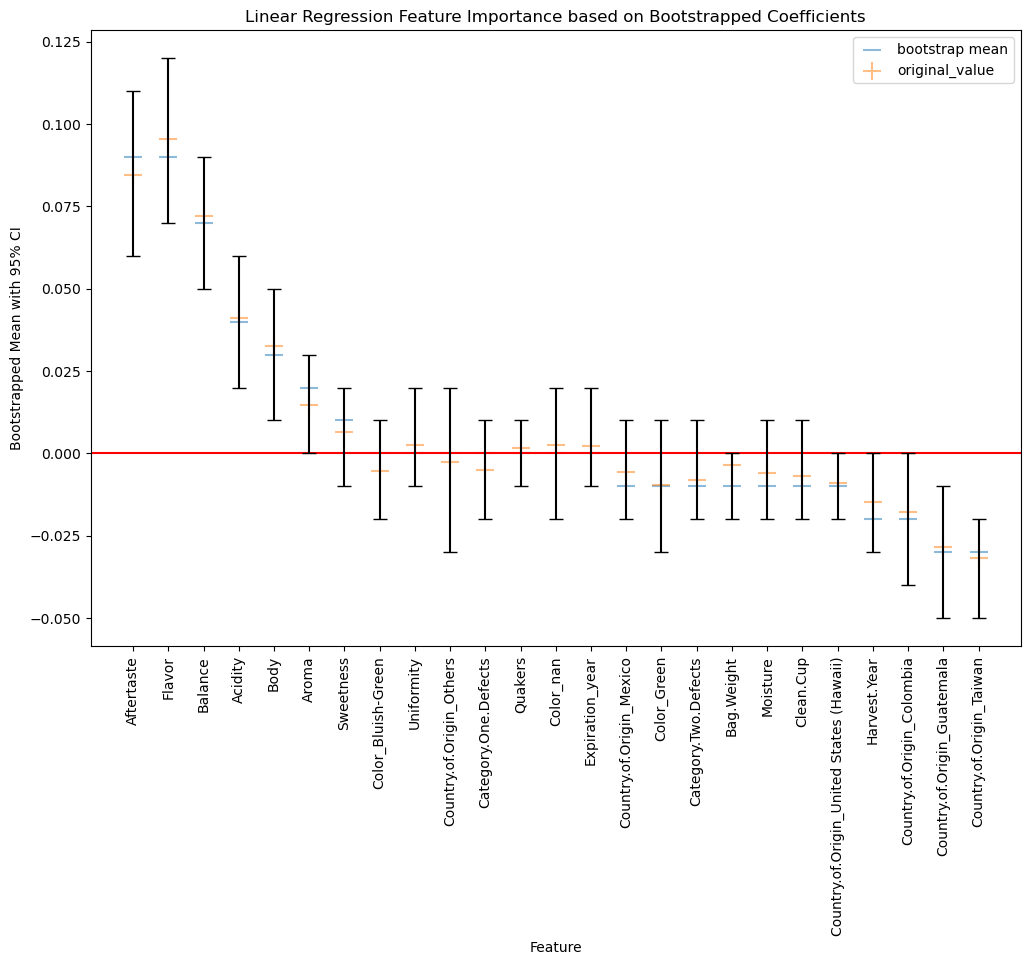

In [37]:
# plot bootstrap feature importances for linear regression
sorted_features = boot_beta_df.sort_values(by='boot_mean', ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))

# Reset the index for proper alignment
sorted_features.reset_index(drop=True, inplace=True)
ax.axhline(y=0, color='r', linestyle='-')
ax.scatter(x="feature", y="boot_mean", data=sorted_features, label="bootstrap mean", marker="_", s=150, alpha = 0.5)
ax.scatter(x="feature", y="original_value", data=sorted_features, label="original_value", marker="+", s=150, alpha = 0.5)

# Add error bars for the 95% CI using the sorted order
ax.errorbar(x=sorted_features.index, y=sorted_features['boot_mean'],
             yerr=[sorted_features['boot_mean'] - sorted_features['95_low'], sorted_features['95_high'] - sorted_features['boot_mean']],
             fmt='none', color='black', capsize=5)
plt.xticks(rotation=90)

ax.set_xlabel('Feature')
ax.set_ylabel('Bootstrapped Mean with 95% CI')
ax.set_title('Linear Regression Feature Importance based on Bootstrapped Coefficients')
plt.legend()
plt.show()


The previous graph allows us to better understand the actual importance of each feature while predicting a coffee general grade.
By looking at it, we can see that only 10 features have an actually meaningful impact.

In further iterations of our work, we will try to use different subset of features (by incorporating categorical features not yet used) to better find the one linked to coffee quality. Linear regression has been chosen as it is an easy to interpret model in that case. We will also try to use decision tree algorithm to have another approach on feature importance.

## Final Model Pipeline:
We combine one-hot encoding, imputing, scaling, and creating a linear regressor into a pipeline.

In [38]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    '''One-hot encode categorical columns and merge with numeric columns'''

    def __init__(self, columns:list=None):
        self.columns = columns
        self.ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore")
        self.transformed_df = None

    def fit(self, X, y=None):
        if self.columns is None:
            self.ohe.fit(X)
        else:
            self.ohe.fit(X[self.columns])
        return self

    def transform(self, X):
        if self.columns is None:
            self.transformed_df = self.ohe.transform(X)
        else:
            self.transformed_df = self.ohe.transform(X[self.columns])
        self.merge(X)
        return self.transformed_df

    def merge(self, X):
        if self.columns is None:
            raise ValueError('Input columns to merge, please.')

        # Drop the original columns and merge with the transformed_df
        self.transformed_df = pd.merge(
            X.drop(columns=self.columns).reset_index(drop=True),
            pd.DataFrame(self.transformed_df, columns=self.ohe.get_feature_names_out()).reset_index(drop=True),
            left_index=True,
            right_index=True
        )
        return self.transformed_df

    def fit_transform(self, X, y=None):
        self.fit(X)
        self.transform(X)
        return self.transformed_df

In [39]:
# Create pipeline
pipeline = Pipeline([
    ('custom_ohe', CustomOneHotEncoder(categorical_cols)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

In [40]:
# Test the new Pipeline
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(train, y,
                                                    test_size = 0.2,
                                                    random_state=209,
                                                    shuffle=True)


# Fit and transform the pipeline on the training data
X_train_transformed = pipeline.fit(X_train_2, y_train_2)

# Predict on the test set
y_pred_test_2 = pipeline.predict(X_test_2)
y_pred_train_2 = pipeline.predict(X_train_2)

# Evaluate the model
score_test = r2_score(y_test_2, y_pred_test_2)
score_train = r2_score(y_train_2, y_pred_train_2)
print(f'Linear regression train score: {score_train:.4f}')
print(f'Linear regression test score: {score_test:.4f}')

Linear regression train score: 0.7677
Linear regression test score: 0.7075


## Tree-based models

### Random Forest Regressor
For our project, we decide to train a Random Forest Regression model on our coffee data. In order to decide on the hyperparameters, we decided to use grid search in order to tune our model's hyperparameters: n_estimators and max_depth. We decided to keep the default criterion of "squared error" for our random forest.

In [41]:
df_train = pd.DataFrame(X_train, columns=imputer.get_feature_names_out())
df_test = pd.DataFrame(X_test, columns=imputer.get_feature_names_out())

In [42]:
# random forest hyper-parameter tuning
param_grid = {
    'n_estimators': [5, 10, 20, 50, 100],
    'max_depth': [2, 5, 7, 9, 15, 20, 25, 30, 35, 40]
}

rf_regressor = RandomForestRegressor(random_state=209)
grid_reg = GridSearchCV(rf_regressor, param_grid, cv=10)
grid_reg.fit(df_train, y_train)

print(f"The best Random Forest parameters: {grid_reg.best_params_} \
with a squared error score of: {grid_reg.best_score_} on the TRAINING data")

The best Random Forest parameters: {'max_depth': 9, 'n_estimators': 100} with a squared error score of: 0.7213120931433485 on the TRAINING data


Looking at the results from the above grid search, since the score wasn't as good as we would like, we decided to tune it a bit more. From the above parameters, we noticed that the max_depth choosen was 9, so we decided to do another grid search that focuses on the values
around 9 and 100.

In [43]:
# more random forest hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 108, 110, 111, 112, 113, 114, 115],
    'max_depth': [8, 9, 10, 11]
}

rf_regressor = RandomForestRegressor(random_state=209)
grid_reg2 = GridSearchCV(rf_regressor, param_grid, cv=10)
grid_reg2.fit(df_train, y_train)

print(f"The best Random Forest parameters: {grid_reg2.best_params_} \
with a squared error score of: {grid_reg2.best_score_:.4f} on the TRAINING data")

KeyboardInterrupt: 

In [ ]:
rfr = grid_reg2.best_estimator_
y_pred_rf = grid_reg2.best_estimator_.predict(df_test)
r2_test_rf = r2_score(y_test, y_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_pred_rf)
print(f"R2 for the Random Forest Model with parameters {grid_reg2.best_params_} on TEST data is {r2_test_rf:.4f}")
print(f"MSE error for the Random Forest Model with parameters {grid_reg2.best_params_} on TEST data is {mse_test_rf:.4f}")

R2 for the Random Forest Model with parameters {'max_depth': 9, 'n_estimators': 112} on TEST data is 0.7780
MSE error for the Random Forest Model with parameters {'max_depth': 9, 'n_estimators': 112} on TEST data is 0.0283


### Bagging models

In [ ]:
# Bagging grid-search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 250, 300, 400, 500, 600]
}

bag_regressor = BaggingRegressor(DecisionTreeRegressor(), random_state=209)
grid_reg_bagging = GridSearchCV(bag_regressor, param_grid, cv=10)
grid_reg_bagging.fit(df_train, y_train)

print(f"The best Bagging Model parameters: {grid_reg_bagging.best_params_} \
with a squared error score of: {grid_reg_bagging.best_score_} on the TRAINING data")

The best Bagging Model parameters: {'n_estimators': 600} with a squared error score of: 0.7218105369287477 on the TRAINING data


### XGBoost Regressor

In [ ]:
## XGBRegressor cross validation
import xgboost as xgb

xgbr = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 8, alpha = 1, n_estimators = 200)

xgbr.fit(X_train_scaled, y_train)

scores = cross_validate(xgbr, X_train_scaled, y_train,
               scoring='r2', cv=10, return_train_score=False)
print("Mean 10-fold CV R2 score for XGB Regression is: ",np.mean(scores['test_score']))

Mean 10-fold CV R2 score for XGB Regression is:  0.7248263869876251


In [ ]:
## XGBOOST GRIDSEARCH
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [8,9,10],
    'n_estimators': [50, 100, 200],
    'alpha':[1,10,12],
    'colsample_bytree':[0.1, 0.3, 1]
}

grid_search = GridSearchCV(estimator=xgbr,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_

# Print the best parameters found by the grid search
print("Best Parameters:", best_params)

Best Parameters: {'alpha': 1, 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


In [ ]:
## FIT XGB REGRESSOR
xgbr = xgb.XGBRegressor(objective ='reg:squarederror', **best_params)

xgbr.fit(X_train_scaled, y_train)

scores = cross_validate(xgbr, X_train_scaled, y_train,
               scoring='r2', cv=10, return_train_score=False)
print("Mean 10-fold CV MSE score for XGB Regression is: ",np.mean(scores['test_score']))

Mean 10-fold CV MSE score for XGB Regression is:  0.726662109320382


## Mean Decrease in Impurity (MDI)
To analyze the feature importances, we first consider the mean decrease in impurity contributed by each feature first within the optimal random forest regressor, then the bagging regressor.

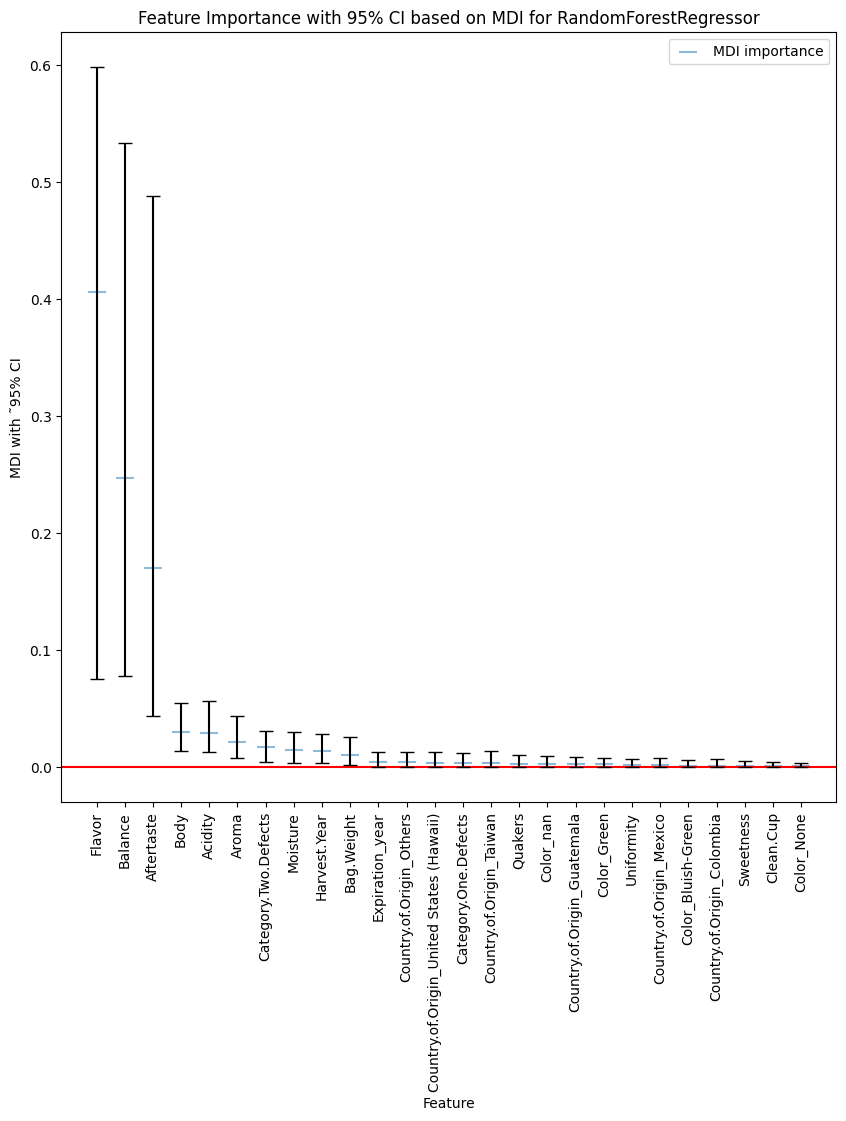

In [ ]:
## RANDOM FOREST MDI
# Get the feature importance values and confidence intervals for those features
importances = grid_reg2.best_estimator_.feature_importances_
imps = [tree.feature_importances_ for tree in grid_reg2.best_estimator_.estimators_]
ci975 = np.percentile(imps, 97.5, axis=0)
ci25 = np.percentile(imps, 2.5, axis=0)

forest_importances = pd.DataFrame({'imp':importances,'name':imputer.get_feature_names_out(), 'ci975':ci975, 'ci25':ci25}).sort_values(by=['imp'], ascending=False)

# Plot the feature importance scores
fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.reset_index(drop=True, inplace=True)
ax.axhline(y=0, color='r', linestyle='-')
ax.scatter(x="name", y="imp", data=forest_importances, label="MDI importance", marker="_", s=150, alpha = 0.5)

# Add error bars for the 95% CI using the sorted order
ax.errorbar(x=forest_importances.index, y=forest_importances['imp'],
            yerr=[forest_importances['imp'] - forest_importances['ci25'], forest_importances['ci975'] - forest_importances['imp']],
            fmt='none', color='black', capsize=5)
plt.xticks(rotation=90)

ax.set_xlabel('Feature')
ax.set_ylabel('MDI with ˜95% CI')
ax.set_title('Feature Importance with 95% CI based on MDI for RandomForestRegressor')
plt.legend()
plt.show()

After plotting the feature importance on Mean Decrease in Impurity, there are 9 features that seem to be important:
- Flavor
- Balance
- Aftertaste
- Acidity
- Body
- Aroma
- Category.Two.Defets
- Moisture
- Harvest.Year

These features can be concluded as important as the confidence interval for Mean Decrease in Impurity doesn't reach 0. It is also important to note that these features closely match, but not exactly, the features found prevously with the linear Regression. Therefore, the features that overlap:
- Flavor
- Balance
- Aftertaste
- Acidity
- Body

might actually be significant in the evaluation of coffee.
On the other hand, Guatamala and Taiwan doesn't seem to be considered as significant in our Random Forest model even though the feature importance plot previously (for linear regression) suggested that they might be.

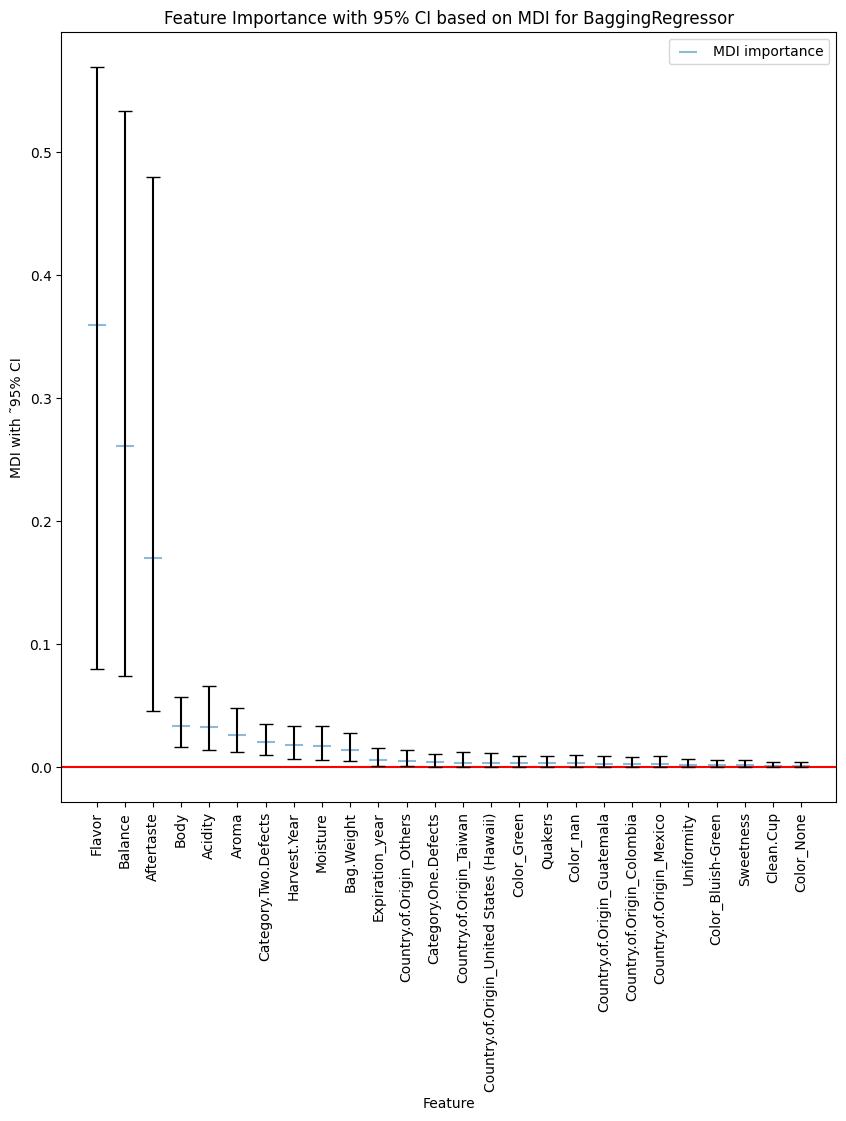

In [ ]:
## BAGGING MDI
# Get the feature importance values and confidence intervals for those features
imps = [tree.feature_importances_ for tree in grid_reg_bagging.best_estimator_.estimators_]
ci975 = np.percentile(imps, 97.5, axis=0)
ci25 = np.percentile(imps, 2.5, axis=0)
importances = np.mean(imps, axis=0)

forest_importances = pd.DataFrame({'imp':importances,'name':imputer.get_feature_names_out(), 'ci975':ci975, 'ci25':ci25}).sort_values(by=['imp'], ascending=False)

# Plot the feature importance scores
fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.reset_index(drop=True, inplace=True)
ax.axhline(y=0, color='r', linestyle='-')
ax.scatter(x="name", y="imp", data=forest_importances, label="MDI importance", marker="_", s=150, alpha = 0.5)

# Add error bars for the 95% CI using the sorted order
ax.errorbar(x=forest_importances.index, y=forest_importances['imp'],
            yerr=[forest_importances['imp'] - forest_importances['ci25'], forest_importances['ci975'] - forest_importances['imp']],
            fmt='none', color='black', capsize=5)
plt.xticks(rotation=90)

ax.set_xlabel('Feature')
ax.set_ylabel('MDI with ˜95% CI')
ax.set_title('Feature Importance with 95% CI based on MDI for BaggingRegressor')
plt.legend()
plt.show()

The above feature importance plot for bagging once again shows similar results as the random forest and linear regression model feature importances. Specifically, the above plot shows that there are 10 important features:
- Flavor
- Balance
- Aftertaste
- Acidity
- Body
- Aroma
- Category.Two.Defets
- Moisture
- Harvest.Year
- Bag.Weight

The features chosen by the random forest model have all also been choosen as important for bagging, the only difference is that bagging also includes Bag.Weight. Therefore, the overlap with the features chosen by the linear regression model are also the same:
- Flavor
- Balance
- Aftertaste
- Acidity
- Body

As such, we can even more confidently conclude that these 5 features are important in deciding the cupper points for coffee.

## Permutation importance
One limitation of MDI as a measure of feature importance is its tendency to favor features with high cardinality, which may bias it against our one-hot encoded variables.  As an alternative, we investigate the permutation importance which measures the mean decrease in the scoring metric when we randomly permute a feature over multiple iterations.

In [ ]:
X_train_df

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Moisture,...,Color_Bluish-Green,Color_Green,Color_None,Color_nan,Country.of.Origin_Colombia,Country.of.Origin_Guatemala,Country.of.Origin_Mexico,Country.of.Origin_Others,Country.of.Origin_Taiwan,Country.of.Origin_United States (Hawaii)
0,0.809087,0.649130,0.772784,0.094196,0.150324,0.368727,0.321720,0.221715,0.228073,-1.841653,...,-0.309943,0.736441,-0.187010,-0.447497,2.305067,-0.414765,-0.444093,-0.687593,-0.241041,-0.228522
1,0.254970,-0.172038,-0.033547,-0.180171,-0.447031,-0.420854,0.321720,0.221715,0.228073,0.654893,...,-0.309943,0.736441,-0.187010,-0.447497,-0.433827,-0.414765,2.251780,-0.687593,-0.241041,-0.228522
2,-0.922529,-1.814374,-1.646210,-1.037569,-0.783043,-1.494685,-2.208379,0.221715,0.228073,1.487075,...,-0.309943,-1.357882,5.347312,-0.447497,-0.433827,-0.414765,2.251780,-0.687593,-0.241041,-0.228522
3,0.532029,1.733073,1.837141,2.392021,1.718382,1.410974,0.321720,0.221715,0.228073,-1.633607,...,-0.309943,-1.357882,-0.187010,2.234652,-0.433827,-0.414765,-0.444093,1.454349,-0.241041,-0.228522
4,-0.610838,-0.730432,-0.323827,0.094196,-0.783043,-0.168188,0.321720,0.221715,0.228073,0.446847,...,-0.309943,0.736441,-0.187010,-0.447497,-0.433827,-0.414765,-0.444093,1.454349,-0.241041,-0.228522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,-1.199588,-1.255980,-1.388184,-1.037569,-0.447031,-1.494685,0.321720,0.221715,0.228073,0.862938,...,-0.309943,0.736441,-0.187010,-0.447497,-0.433827,-0.414765,-0.444093,1.454349,-0.241041,-0.228522
943,-0.333780,-0.434812,-0.323827,0.094196,-0.783043,-0.168188,0.321720,0.221715,0.228073,0.862938,...,3.226397,-1.357882,-0.187010,-0.447497,-0.433827,-0.414765,-0.444093,1.454349,-0.241041,-0.228522
944,-0.610838,-0.730432,-0.581853,-0.454538,-0.148353,-0.420854,0.321720,0.221715,0.228073,0.654893,...,-0.309943,0.736441,-0.187010,-0.447497,-0.433827,-0.414765,-0.444093,1.454349,-0.241041,-0.228522
945,-0.056721,-0.172038,-0.033547,0.094196,-0.148353,-0.168188,0.321720,0.221715,0.228073,0.030756,...,-0.309943,0.736441,-0.187010,-0.447497,-0.433827,-0.414765,-0.444093,1.454349,-0.241041,-0.228522


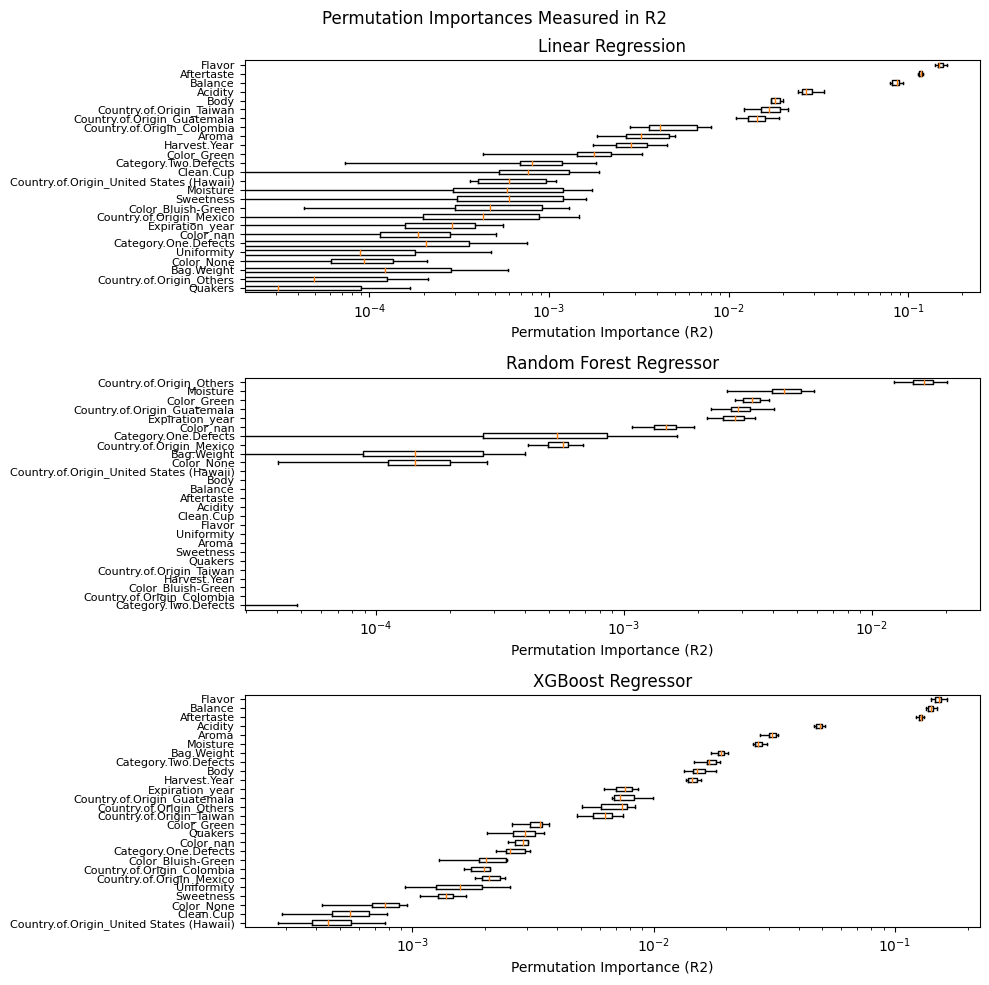

In [ ]:
# from sklearn docs: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, scoring='r2',
                                    n_repeats=10, random_state=209, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False, showfliers = False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.set_xlabel("Permutation Importance (R2)")
    ax.set_xscale("log")
    ax.set_yticklabels(X.columns[perm_sorted_idx], fontsize=8)
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

lr = LinearRegression()
lr.fit(X_train_df,y_train)

fig, axs = plt.subplots(3,1, figsize=(10,10))
plot_permutation_importance(lr, pd.DataFrame(X_train_scaled, columns = X_train_df.columns), y_train, axs[0])
axs[0].set_title("Linear Regression")
plot_permutation_importance(rfr, pd.DataFrame(X_train_scaled, columns = X_train_df.columns), y_train, axs[1])
axs[1].set_title("Random Forest Regressor")
plot_permutation_importance(xgbr, pd.DataFrame(X_train_scaled, columns = X_train_df.columns), y_train, axs[2])
axs[2].set_title("XGBoost Regressor")
plt.suptitle("Permutation Importances Measured in R2")
plt.tight_layout()

After plotting the permutation importance from three different models: Linear Regression, Random Forest, and XGBoost Regressor, the features that are consistently the most important are:
- Flavor
- Balance
- Aftertaste

Of medium importance are the features:
- Acidity
- Aroma
- Body

The effect of other features on the total cup points is marginal. This is consistent with the features identified as important according to MDI. However, permutation importance reveals an even more distinct difference in feature importance between flavor, balance, and aftertaste and the other features as compared with the MDI.

As expected, the features related to country of origin are more important to the total cup points than the MDI would indicate, and we know from the simple linear regression coefficients that coffee from Taiwan, Guatemala, and Colombia are related to a decrease in the total cup points.

## Lasso Regression

In [44]:
# Define your list of lambdas (alphas)
alphas = np.logspace(-1, -5, 5)

# Create pipeline
lasso_pipeline = Pipeline([
    ('custom_ohe', CustomOneHotEncoder(categorical_cols)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', LassoCV(alphas=alphas, cv=5, random_state=42))  # Use LassoCV for cross-validated Lasso regression
])

# Fit and transform the pipeline on the training data
X_train_transformed = lasso_pipeline.fit(X_train_2, y_train_2)

# Get the best alpha
best_alpha = lasso_pipeline.named_steps['regressor'].alpha_
print('Best Alpha:', best_alpha)

lassoCV_val_mses_mean = lasso_pipeline.named_steps['regressor'].mse_path_.mean(axis=1)

Best Alpha: 0.001


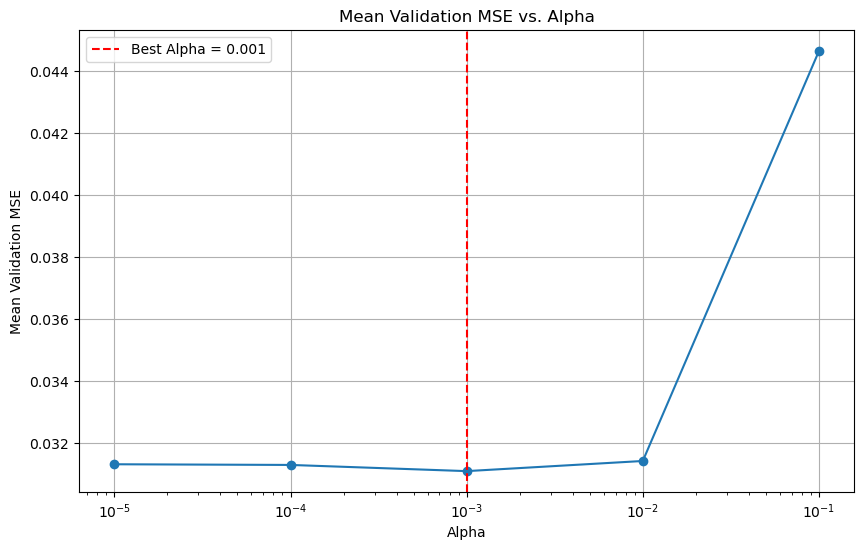

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, lassoCV_val_mses_mean, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Validation MSE')
plt.title('Mean Validation MSE vs. Alpha')
plt.xscale('log')
plt.grid(True)

plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Best Alpha = {best_alpha}')
plt.legend()

plt.show()

In [46]:
lasso_pipeline_2 = Pipeline([
    ('custom_ohe', CustomOneHotEncoder(categorical_cols)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', Lasso(alpha=best_alpha, random_state=42))  # Use LassoCV for cross-validated Lasso regression
])

X_train_transformed = lasso_pipeline_2.fit(X_train_2, y_train_2)

# Predict on the test set
y_pred_test_2 = lasso_pipeline_2.predict(X_test_2)
y_pred_train_2 = lasso_pipeline_2.predict(X_train_2)

# Evaluate the model
score_test = r2_score(y_test_2, y_pred_test_2)
score_train = r2_score(y_train_2, y_pred_train_2)
print('Lasso regression train score:', score_train)
print('Lasso regression test score:', score_test)

Lasso regression train score: 0.7671716832161994
Lasso regression test score: 0.7107473535464102


In [51]:
imputer.get_feature_names_out()

25

In [50]:
coefficients = lasso_regressor.coef_
len(coefficients)

25

In [52]:
lasso_regressor = lasso_pipeline_2.named_steps['regressor']
coefficients = lasso_regressor.coef_
coefficients_dict = {feature: coefficient for feature, coefficient in zip(imputer.get_feature_names_out(), coefficients)}
print('Lasso regression coefficients:')
for feature, coefficient in coefficients_dict.items():
    print(f'{feature}: {coefficient}')


Lasso regression coefficients:
Aroma: 0.0169324658717908
Flavor: 0.10349636594329231
Aftertaste: 0.0869520736481616
Acidity: 0.034987255038178317
Body: 0.027161489523807484
Balance: 0.07360587376721771
Uniformity: -0.005861899599703706
Clean.Cup: 0.012043461724827061
Sweetness: 0.0006183234052196055
Moisture: -0.00926780133793393
Category.One.Defects: -0.0067802208918675
Quakers: 0.002237151037694528
Category.Two.Defects: -0.0030675590075907332
Harvest.Year: -0.01112210435576082
Bag.Weight: 0.0005514883223160216
Expiration_year: 0.0010960441416800572
Color_Bluish-Green: -0.0024373927602195705
Color_Green: -0.0033597857228481933
Color_nan: 0.0
Country.of.Origin_Colombia: -0.019263599206941498
Country.of.Origin_Guatemala: -0.026327496838187008
Country.of.Origin_Mexico: -4.830051756207737e-05
Country.of.Origin_Others: -0.000549004237552136
Country.of.Origin_Taiwan: -0.02696483919061288
Country.of.Origin_United States (Hawaii): -0.004855464983250122


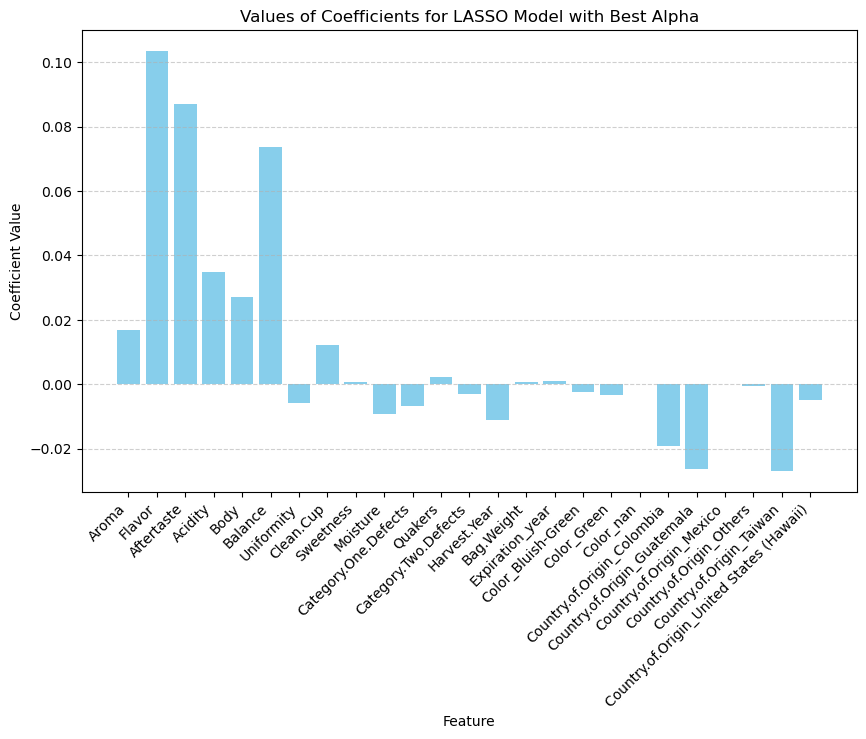

In [53]:
plt.figure(figsize=(10, 6))
plt.bar(coefficients_dict.keys(), coefficients_dict.values(), color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Values of Coefficients for LASSO Model with Best Alpha')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Adjusted to grid on y-axis for better visibility

plt.show()

Number of times each predictor is significant:
Predictor Aroma: 13 times significant
Predictor Flavor: 100 times significant
Predictor Aftertaste: 100 times significant
Predictor Acidity: 69 times significant
Predictor Body: 44 times significant
Predictor Balance: 100 times significant
Predictor Uniformity: 0 times significant
Predictor Clean.Cup: 2 times significant
Predictor Sweetness: 0 times significant
Predictor Moisture: 0 times significant
Predictor Category.One.Defects: 0 times significant
Predictor Quakers: 0 times significant
Predictor Category.Two.Defects: 0 times significant
Predictor Harvest.Year: 0 times significant
Predictor Bag.Weight: 0 times significant
Predictor Expiration_year: 0 times significant
Predictor Color_Bluish-Green: 0 times significant
Predictor Color_Green: 3 times significant
Predictor Color_nan: 0 times significant
Predictor Country.of.Origin_Colombia: 17 times significant
Predictor Country.of.Origin_Guatemala: 52 times significant
Predictor Country.of

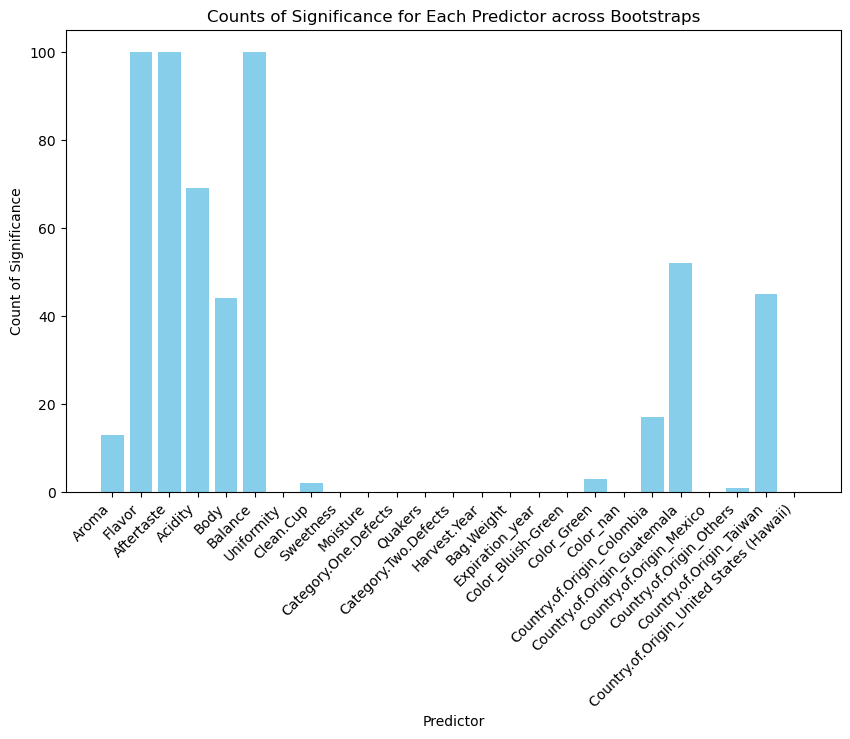

In [64]:
n_bootstraps = 100
predictor_counts = {col: 0 for col in imputer.get_feature_names_out()}
boot_betas = []

for i in range(n_bootstraps):
    bootstrap_indices = np.random.choice(len(X_train_2), len(X_train_2), replace=True)
    X_bootstrap = X_train_2.iloc[bootstrap_indices]
    y_bootstrap = y_train_2.iloc[bootstrap_indices]

    lasso_pipeline_2.fit(X_bootstrap, y_bootstrap)

    coefficients = lasso_pipeline_2.named_steps['regressor'].coef_
    boot_betas.append(coefs)
    significant_predictors = np.abs(coefficients) > 0.03

    for predictor, is_significant in zip(predictor_counts.keys(), significant_predictors):
        if is_significant:
            predictor_counts[predictor] += 1

# Display counts of significant predictors
print(f'Number of times each predictor is significant:')
for predictor, count in predictor_counts.items():
    print(f'Predictor {predictor}: {count} times significant')

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(predictor_counts.keys(), predictor_counts.values(), color='skyblue')
plt.xlabel('Predictor')
plt.ylabel('Count of Significance')
plt.title('Counts of Significance for Each Predictor across Bootstraps')
plt.xticks(rotation=45, ha='right')
plt.show()


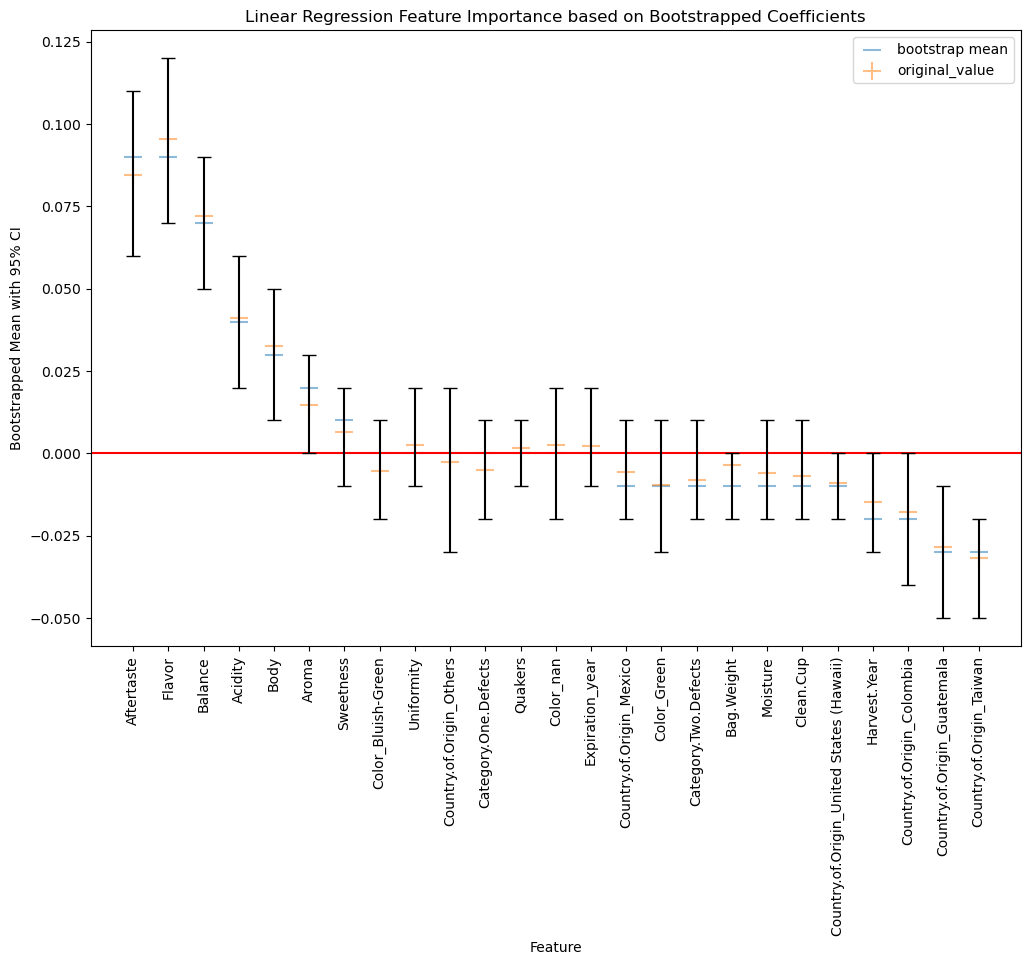

In [66]:
sorted_features = boot_beta_df.sort_values(by='boot_mean', ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))

# Reset the index for proper alignment
sorted_features.reset_index(drop=True, inplace=True)
ax.axhline(y=0, color='r', linestyle='-')
ax.scatter(x="feature", y="boot_mean", data=sorted_features, label="bootstrap mean", marker="_", s=150, alpha = 0.5)
ax.scatter(x="feature", y="original_value", data=sorted_features, label="original_value", marker="+", s=150, alpha = 0.5)

# Add error bars for the 95% CI using the sorted order
ax.errorbar(x=sorted_features.index, y=sorted_features['boot_mean'],
             yerr=[sorted_features['boot_mean'] - sorted_features['95_low'], sorted_features['95_high'] - sorted_features['boot_mean']],
             fmt='none', color='black', capsize=5)
plt.xticks(rotation=90)

ax.set_xlabel('Feature')
ax.set_ylabel('Bootstrapped Mean with 95% CI')
ax.set_title('Lasso Regression Feature Importance based on Bootstrapped Coefficients')
plt.legend()
plt.show()

## Knn Regression

We train a knn regression model and choose the best parameter `n_neighbors` by cross validation. We find that the model underfroms linear regression model.

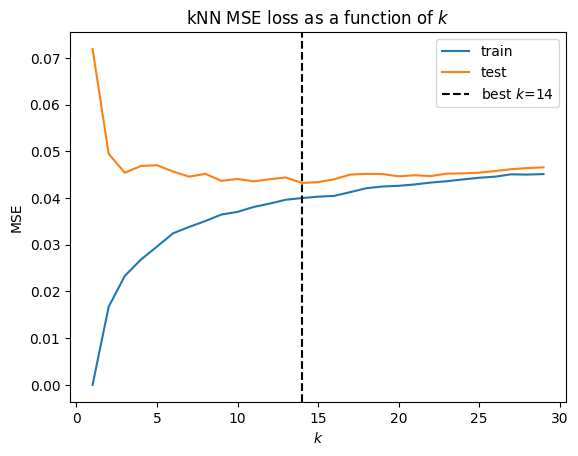

In [ ]:
ks = range(1, 30)
# lists to store train and test MSEs
train_mses = []
test_mses = []
# fit a model for each k and record MSEs
for k in ks:
    cur_knn = KNeighborsRegressor(n_neighbors=k).fit(X_train_scaled, y_train)
    train_mses.append(mean_squared_error(y_train, cur_knn.predict(X_train_scaled)))
    test_mses.append(mean_squared_error(y_test, cur_knn.predict(X_test_scaled)))


# argmin gives the index of the lowest test MSE
best_idx = np.argmin(test_mses)
# which we cna use to select the k that corresponds to that minimum loss
best_k = ks[best_idx]

plt.plot(ks, train_mses, label='train')
plt.plot(ks, test_mses, label='test')
plt.axvline(best_k, c='k', ls='--', label=rf'best $k$={best_k}')
plt.xlabel(r'$k$')
plt.ylabel('MSE')
plt.title('kNN MSE loss as a function of $k$')
plt.legend();

In [ ]:
# knn with best k
best_knn = KNeighborsRegressor(n_neighbors=best_k).fit(X_train_scaled, y_train)

# Evaluate the model
score_test = best_knn.score(X_test_scaled, y_test)
score_train = best_knn.score(X_train_scaled, y_train)
print('Knn regression train score: {:.5f}'.format(score_train))
print('Knn regression test score: {:.5f}'.format(score_test))

Knn regression train score: 0.67506
Knn regression test score: 0.66135


## Stacking

We combine the previous models in a stacking model and use a simple linear regression as the final estimator, the stacking model gives a test score higher than individual models.

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train_df.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_train_df.columns)

In [ ]:
estimators = [('lr', lr),
              ('rf', rfr),
              ('xgb', xgbr),
              ('knn', best_knn)
             ]

final_estimator = LinearRegression()


reg = StackingRegressor(estimators=estimators, final_estimator=final_estimator)

reg.fit(X_train_scaled, y_train)

y_train_pred = reg.predict(X_train_scaled)
y_test_pred = reg.predict(X_test_scaled)

print('Stacking train score: {:.5f}'.format(r2_score(y_train, y_train_pred)))
print('Stacking test score: {:.5f}'.format(r2_score(y_test, y_test_pred)))

Stacking train score: 0.82097
Stacking test score: 0.78009


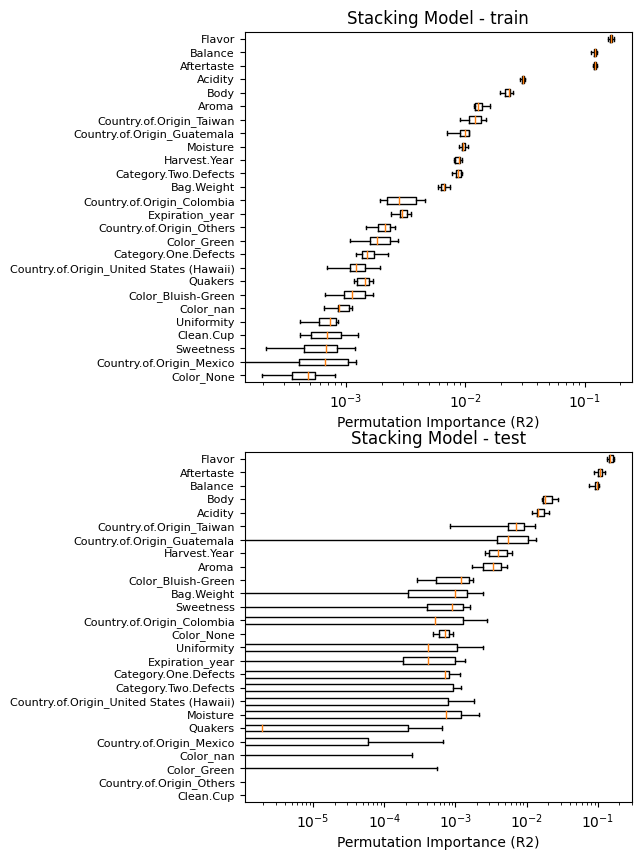

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(5,10))
plot_permutation_importance(reg, X_train_scaled, y_train, ax[0])
plot_permutation_importance(reg, X_test_scaled, y_test, ax[1])
ax[0].set_title("Stacking Model - train");
ax[1].set_title("Stacking Model - test");

The permutation score are similar to individual models, we consistently find Flavor, Balance, and Aftertaste are the most important predictors in the training process (R2 decreases by around 0.1 after permutating those predictors), they also contribute most to test score.